In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
chunksize = 370 #approximately 31685708 entries

df = pd.DataFrame()
curr_chunk = 0
data=pd.read_csv('all_skills_sorted.tsv', sep='\t', chunksize=chunksize)

for chunk in data:
    rand_person = chunk.sample(n=1)
    df = pd.concat([df, rand_person])
    
    # log progress
    curr_chunk += 1
    if curr_chunk % 10000 == 0:
        print(curr_chunk)

df.columns = ['subclass', 'skills']
df

10000
20000
30000
40000
50000
60000
70000
80000


,subclass,skills
176,"[('Accounting and Auditing', 0.145283922405661...","Microsoft Office,Marketing,E-commerce,Customer..."
406,"[('Accounting and Auditing', 0.156188003753166...","Project Management,Photovoltaics,Renewable Ene..."
905,"[('Accounting and Auditing', 0.170539772259657...","Analysis,Financial Analysis,Strategy,Leadershi..."
1307,"[('Accounting and Auditing', 0.177412252433394...","Dutch,Economics,Finance,English,Market Researc..."
1750,"[('Accounting and Auditing', 0.183642447694312...","Microsoft Office,Customer Service,Public Speak..."
2050,"[('Accounting and Auditing', 0.187495216128198...","Microsoft Office,Sales,Accounting,Adobe Acroba..."
2359,"[('Accounting and Auditing', 0.190730029921701...","English,Financial Analysis,Financial Reporting..."
2855,"[('Accounting and Auditing', 0.195404449292250...","Vendor Management,IT Governance,Information Te..."
3129,"[('Accounting and Auditing', 0.197540624174238...","Business Analysis,Accounting,Financial Reporti..."
3601,"[('Accounting and Auditing', 0.201135958546547...","Licensing,Brand Management,Relationship Manage..."


In [34]:
counts = {}
for subclass in df['subclass']:
    if isinstance(subclass, str):
        curr = subclass.split(',')[0]
    else:
        continue
    if curr in counts:
        counts[curr] += 1
    else:
        counts[curr] = 1
print(counts.values())

dict_values([2419, 6458, 2265, 10762, 1883, 1101, 1233, 2015, 1695, 1875, 2062, 1717, 2793, 1440, 1836, 1126, 609, 872, 1863, 1234, 1430, 1633, 1674, 1306, 888, 1007, 2036, 1640, 1059, 1682, 1480, 1423, 1054, 1871, 1606, 1822, 2235, 2187, 1599, 1682, 1854, 1318, 1181, 2712])


In [15]:
corpus = []
for skills in df['skills']:
    corpus.append(skills)
print(str(len(corpus)) + ' sampled people')

85638 sampled people


In [4]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','), min_df=10) #drop sparse entries < 10 in corpus
data_vectorized = normalize(vectorizer.fit_transform(corpus))

# convert sparse matrix to full
data_processed = data_vectorized.toarray()
print(data_processed.shape)

/Users/ericgan/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


(85638, 9208)


In [5]:
lda = LatentDirichletAllocation(n_topics=44, max_iter=500) #change max_iter to 500
lda_output = lda.fit_transform(data_processed)
print(lda)
print(lda_output.shape)
print(lda.components_.shape)

/Users/ericgan/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=500,
             mean_change_tol=0.001, n_jobs=1, n_topics=44, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
(85638, 44)
(44, 9208)


In [6]:
# higher the better
print(lda.score(data_vectorized))

# lower the better
print(lda.perplexity(data_vectorized))

-12719366.650565835
1.4662861342798834e+16


In [7]:
# column names
skillsets = ["Skill" + str(i) for i in range(lda.n_topics)]
# row names
people = ["Person" + str(i) for i in range(len(data_vectorized.toarray()))]

# create data frame relating people to each of the skillsets
df_people_skills = pd.DataFrame(np.round(lda_output, 2), columns=skillsets, index=people)

# Get dominant skill for each person
dominant_skill = np.argmax(df_people_skills.values, axis=1)
df_people_skills['Dominant Skill'] = dominant_skill

df_people_skills.head(15)

,Skill0,Skill1,Skill2,Skill3,Skill4,Skill5,Skill6,Skill7,Skill8,Skill9,...,Skill35,Skill36,Skill37,Skill38,Skill39,Skill40,Skill41,Skill42,Skill43,Dominant Skill
Person0,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00,21
Person1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.52,0.00,0.00,0.05,0.04,0.00,38
Person2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.42,0.00,0.00,0.09,0.03,0.00,38
Person3,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.16,0.01,0.01,21
Person4,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.36,0.01,0.01,0.15,0.01,0.01,38
Person5,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21
Person6,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.00,0.00,21
Person7,0.00,0.00,0.00,0.00,0.00,0.26,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.00,0.00,21
Person8,0.00,0.00,0.00,0.00,0.48,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.25,0.00,0.00,0.11,0.00,0.00,4
Person9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.17,0.45,0.00,0.02,0.23,0.00,0.00,38


In [8]:
df_skill_distribution = df_people_skills['Dominant Skill'].value_counts().reset_index(name='skill counts')
df_skill_distribution.columns = ['Skill Num', 'Num People']
df_skill_distribution

,Skill Num,Num People
0,21,34510
1,38,15491
2,9,5613
3,13,5514
4,23,4948
5,41,3039
6,4,3001
7,8,2706
8,19,2560
9,5,1841


<Container object of 44 artists>

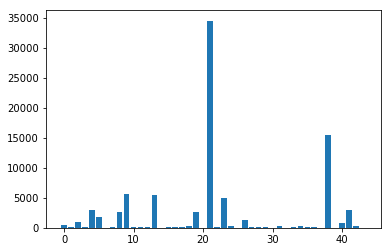

In [9]:
plt.bar(df_skill_distribution['Skill Num'], df_skill_distribution['Num People'])

In [10]:
# Topic-Keyword Matrix
df_skill_keywords = pd.DataFrame(lda.components_)
# Assign Column and Index
df_skill_keywords.columns = vectorizer.get_feature_names()
df_skill_keywords.index = skillsets

df_skill_keywords.head()

,.net,.net compact framework,.net framework,10 key,1031 exchanges,21 cfr part 11,2d graphics,2g,35mm,360 feedback,...,经营策略,英语,营销,营销战略,谈判,销售管理,项目管理,项目规划,顾客服务,领导力
Skill0,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,...,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727
Skill1,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,...,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727
Skill2,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,...,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727
Skill3,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,...,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727
Skill4,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,...,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727


In [11]:
# Show top k keywords for each skill
def show_topics(vectorizer, lda_model, k_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        # sort in descending order
        top_keyword_idx = (-topic_weights).argsort()[:k_words]
        topic_keywords.append(keywords.take(top_keyword_idx))
    return topic_keywords

In [12]:
# Topic - Keywords Dataframe
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda, k_words=15)
df_skill_keywords = pd.DataFrame(topic_keywords)
df_skill_keywords.columns = ['Word '+ str(i) for i in range(df_skill_keywords.shape[1])]
df_skill_keywords.index = ['Skill '+ str(i) for i in range(df_skill_keywords.shape[0])]
df_skill_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Skill 0,customer experience,e-commerce,dentrix,mobile marketing,contact centers,online-marketing,onlinewerbung,droit des contrats,marketingstrategie,produktmanagement,unternehmensstrategie,managed services,hair cutting,digitale strategie,web project management
Skill 1,software development,it strategy,it management,surgery,recherche,cms,orthopedic,sports medicine,nuclear power plants,enterprise architecture,solution architecture,pmo,orthopedics,infrastructure,java enterprise edition
Skill 2,marketing communications,marketing,marketing strategy,real estate,fashion,social media,investment properties,market research,real estate transactions,advertising,first time home buyers,e-commerce,commercial real estate,short sales,google analytics
Skill 3,strategische planung,vertrieb,geschäftsführung,gesprächsführung,unternehmensstrategie,verkaufsleitung,marketingstrategie,produktentwicklung,vertragsverhandlungen,strategisches management,account-management,baugewerbe,prozessverbesserung,fertigung,automobilindustrie
Skill 4,project planning,project management,engineering,contract management,energy,petroleum,microsoft project,ms project,gas,procurement,dutch,change management,oil & gas,contract negotiation,internal controls
Skill 5,javascript,html,css,mysql,php,sdlc,web development,html5,security,software engineering,disaster recovery,network security,information technology,information security,software design
Skill 6,dreamweaver,mac,logistics management,makeup artistry,adobe acrobat,freelance writing,ios,experience working with children,rhino 3d,sage accounts,coffee,barista,signs,microsoft works,following up
Skill 7,commissioning,illustration,legal advice,legal assistance,data mining,flash,publicity,language teaching,receptionist duties,ios development,community organizing,office 365,windows 8,scala,smo
Skill 8,autocad,sql,microsoft sql server,web design,troubleshooting,oracle,microsoft office,project engineering,windows server,windows,databases,civil engineering,electronics,pl/sql,.net
Skill 9,microsoft office,microsoft excel,microsoft word,powerpoint,management,customer service,leadership,project management,gestion de projet,marketing,social media,technical support,service client,anglais,stratégie commerciale


In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
panel